In [1]:
from scipy import stats, integrate, special, optimize
from matplotlib import pyplot as plt
import numpy as np
import math

### Define the number of expected background events, its error and the number of observed events:

In [2]:
ExpectedBG = 9.3#expected BG
BGError = 2.2 #BG uncertainty
Nobs = 9 #Observed number of events

Nsig = 9.6
sigError = 0.2*Nsig

### Use toy experiments to get the BG distribution

In [3]:
NumToyExperiments = 100000
#First select an expected number of BG events using a gaussian distribution:
ExpectedBGs = stats.norm.rvs(loc=ExpectedBG, scale=BGError,
                                    size=NumToyExperiments)
ExpectedBGs = [value for value in ExpectedBGs if value > 0] #Remove negative BG values
 

# For each toy experiment, get the actual number of background events by
# taking one value from a Poisson distribution created using the expected
# number of events previously selected.
ToyBGs = map(stats.poisson.rvs, ExpectedBGs)
ToyBGs = list(map(float, ToyBGs))

#### The above procedure generates the expected statistical distribution of events considering 
### all possible values for the BG,
### so it corresponds to the marginalized lileklihood L(n).

### Analytically define a marginalized and profile likelihood:

In [4]:
@np.vectorize
def likelihood(theta,nobs,nbg,bgError,nsig=0,sigError=0.):
    lmbda = nbg + nsig + theta
    poisson = stats.poisson.pmf(int(nobs), lmbda)
    gaussian = stats.multivariate_normal.pdf(theta,mean=0.,cov=bgError**2+sigError**2)
    
    return gaussian*poisson

@np.vectorize
def profileLikelihood(nobs,nbg,bgError,nsig=0,sigError=0.,disp=False):
    
    f = lambda x: -likelihood(x,nobs,nbg,bgError,nsig,sigError)
    
    theta_guess = nobs-nsig-nbg
    
    theta_max,lmax,niter,funcalls,warnflag = optimize.fmin(f, theta_guess,full_output=True,disp=disp)
    
    return -lmax

### Using profile likehoods, compare their results with the distribution obtained from the toy experiments:

/home/lessa/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


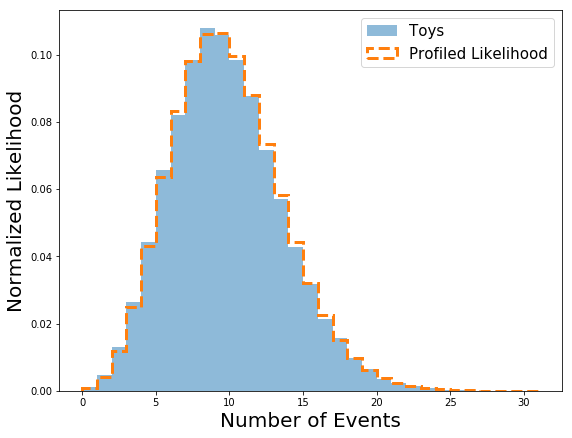

In [5]:
fig = plt.figure(figsize=(9,7))
dbin = max(1,int((max(ToyBGs)-min(ToyBGs))/500.))
bins = [i for i in range(int(min(ToyBGs)),int(max(ToyBGs)),dbin)]
profPoisPts = profileLikelihood(bins,ExpectedBG,BGError)
bToys,_,_ = plt.hist(ToyBGs,bins=bins,normed=True,alpha=0.5,label='Toys')
bProf,_,_ = plt.hist(bins,bins=bins,weights=profPoisPts,normed=True,histtype='step',
         label='Profiled Likelihood',linewidth=3,linestyle='--')
plt.xlabel('Number of Events',size=20)
plt.ylabel('Normalized Likelihood',size=20)
plt.legend(fontsize=15)
plt.show()

In [6]:
#Intregrate each histogram to compute the probability for finding n <= Nobs:
pToys = sum([x for i,x in enumerate(bToys) if bins[i] <= Nobs])
pProf = sum([x for i,x in enumerate(bProf) if bins[i] <= Nobs])
print('pToys= ',pToys,'\npProf=',pProf)

pToys=  0.5486509730194604 
pProf= 0.5422189671635589


### Now the same must be done for the signal+BG hypotesis

In [7]:
#First select an expected number of BG events using a gaussian distribution:
Expected = stats.norm.rvs(loc=(ExpectedBG+Nsig), scale=np.sqrt(BGError**2+sigError**2),
                                    size=NumToyExperiments)
Expected = [value for value in Expected if value > 0] #Remove negative BG values
ToyBGSig = map(stats.poisson.rvs, Expected)
ToyBGSig = list(map(float, ToyBGSig))

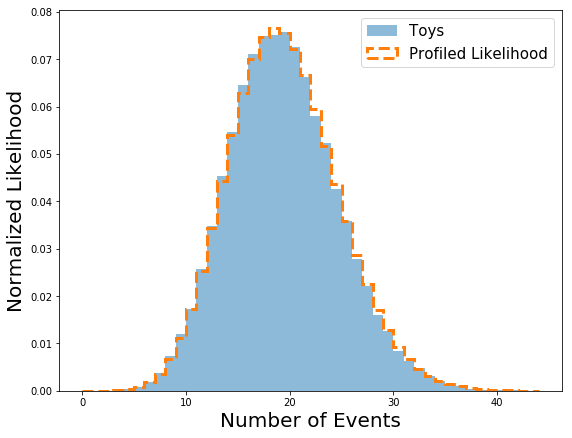

In [8]:
fig = plt.figure(figsize=(9,7))
dbin = max(1,int((max(ToyBGSig)-min(ToyBGSig))/500.))
bins = [i for i in range(int(min(ToyBGSig)),int(max(ToyBGSig)),dbin)]
profPoisPts = profileLikelihood(bins,ExpectedBG,BGError,Nsig,sigError)
bToys,_,_ = plt.hist(ToyBGSig,bins=bins,normed=True,alpha=0.5,label='Toys')
bProf,_,_ = plt.hist(bins,bins=bins,weights=profPoisPts,normed=True,histtype='step',
         label='Profiled Likelihood',linewidth=3,linestyle='--')
plt.xlabel('Number of Events',size=20)
plt.ylabel('Normalized Likelihood',size=20)
plt.legend(fontsize=15)
plt.show()

In [9]:
#Intregrate each histogram to compute the probability for finding n <= Nobs:
pToysSig = sum([x for i,x in enumerate(bToys) if bins[i] <= Nobs])
pProfSig = sum([x for i,x in enumerate(bProf) if bins[i] <= Nobs])
print('pToysSig= ',pToysSig,'\npProfSig=',pProfSig)

pToysSig=  0.02628052561051221 
pProfSig= 0.024301604715570673


In [10]:
# For a single channel:
#CLs = P(n <= Nobs; BG+Signal)/P(n <= Nobs; BG+Signal) --> Equation (12) of CERN-OPEN-2000-205
#If 1 - CLs >= 0.95 -> Signal is excluded at 95% C.L.
CLsToy = pToysSig/pToys
CLsProf = pProfSig/pProf
print('1-CLsToys= ',1-CLsToy,'\n1-CLsProf=',1-CLsProf)

1-CLsToys=  0.9520997375328084 
1-CLsProf= 0.9551811976576612
